In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import os
from matplotlib.ticker import FixedLocator, FormatStrFormatter

# Save the current style settings
# original_rc_params = mpl.rcParams.copy()

# Set a Seaborn style
sns.set_style("white")
sns.set_palette(palette='Dark2')

plt.rcParams.update({"text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
 "text.latex.preamble": r"""
        \usepackage{amsmath}
        \usepackage{mathptmx}
        \usepackage{bm}
    """
})

%matplotlib inline

# get data and predictions

In [2]:
# particular_path = '2dcosk5_hu200_hdata'
# particular_path = '2dgauss_double_hdata/test2'
# particular_path = '2dgauss_double_hdata/test3'
# particular_path = '2dgauss_double_hdata/fixed_buoys'
# particular_path = '2dgauss_double_hdata/fixedbuoys_sampleprob'
particular_path = '2dgauss_double_hdata/alpha_test'

# particular_path = 'fixed_buoys/2dcosk5_fixed_buoys'
# particular_path = 'fixed_buoys/2D_GD_fixed_buoys'

parent_path = f'./{particular_path}'
ckpt_folder = 't220'
path = parent_path + '/' + ckpt_folder

frames_path = parent_path + '/time_frames'

dt = 2.5e-2

# fig_path = parent_path +'/2dcosk5_hu200_hdata_figures'
fig_path = parent_path +'/figures'
# fig_path = parent_path +'/2dcosk5_hu200_figures'
# fig_path = parent_path +'/2dgauss_double_figures'
%matplotlib inline

In [8]:
try:
    rs = [r for r in os.listdir(path) if (r.startswith('ref') and r.endswith('.npy'))]
    rs.remove('ref.npy')
    # sort the ref frames
    ref_tidxs = []
    for word in rs:
        number = ''
        for l in word:
            if l.isnumeric():
                number = number + l
        ref_tidxs.append(int(number))

    ref_dict ={t:r for t,r in zip(ref_tidxs , rs)}
    print(ref_dict)
    rs = [ref_dict[key] for key in sorted(ref_dict.keys())]
    print('rs  =  ' , rs)
    refs = [np.load(f'{path}/{r}') for r in rs]

    # same for predicted
    ps = [p for p in os.listdir(path) if (p.startswith('predicted') and p.endswith('.npy'))]
    ps.remove('predicted.npy')
    # sort predicted frames
    p_tidxs = []
    for word in ps:
        number = ''
        for l in word:
            if l.isnumeric():
                number = number + l
        p_tidxs.append(int(number))

    p_dict ={t:r for t,r in zip(p_tidxs , ps)}
    print(p_dict)
    ps = [p_dict[key] for key in sorted(p_dict.keys())]
    print('ps  =  ' , ps)
    pinns = [np.load(f'{path}/{p}') for p in ps]

    # now sort frame numbers, and get actual times
    ref_tidxs.sort()
    p_tidxs.sort()

    ts = np.array(ref_tidxs)*dt

    print('\n ts  =  ' , ts)
except:
    print("no multiple ref and predicted files to get")

{}
rs  =   []
{}
ps  =   []

 ts  =   []


In [3]:
L = 2*np.pi/4
eta0 = 0.05
h0 = 1
c = 1
tL = L/c

################
ref = np.load(f'{path}/ref.npy')
HB = ref[-1]/h0

ref120 = np.load(f'{frames_path}/ref120.npy')
U = ref120[0]/c
V = ref120[1]/c
ETA = (ref120[2]-h0)/eta0

#################
pinn = np.load(f'{path}/predicted.npy')
hb = pinn[-1]/h0

predicted120 = np.load(f'{frames_path}/predicted120.npy')
u = (predicted120[0] - predicted120[0].mean())/c
v = (predicted120[1] - predicted120[1].mean())/c
eta = (predicted120[2]-h0)/eta0


loss = np.loadtxt(f'{path}/output.dat', unpack=True)
val = np.loadtxt(f'{path}/validation.dat' , unpack=True)
bal = np.loadtxt(f'{path}/balance.dat' , unpack=True)

N = len(ref[0])
domain = np.linspace(0,2*np.pi, N)/L
x = np.linspace(0, 2*np.pi, N)/L
y = np.linspace(0, 2*np.pi, N)/L
X, Y = np.meshgrid(x, y)

# print('h.mean()   =   ' ,   h.mean(), 'H.mean()   =   ' ,   H.mean())

%matplotlib inline

In [4]:
def RSE_hb(hb,HB, X, Y, normalization = 'max'):
    if normalization=='max':
        return np.sqrt((hb - HB) ** 2) / np.max(HB)
    elif normalization=='integral':
        # integrate in x
        norm = np.trapz(HB, X)
        # integrate in y
        norm = np.trapz(norm, Y)/(X.max()*Y.max())

        return np.sqrt((hb - HB) ** 2) / norm

def RSE_u(u,U, X, Y, tts=None, normalization = 'max'):
    if normalization=='max':
        return np.sqrt((u - U) ** 2) / np.max(U)

    elif normalization=='integral':
        # integrate in x
        norm = np.trapz(U, X)
        # integrate in y
        norm = np.trapz(norm, Y)
        # integrate in t
        norm = np.trapz(norm, tts)/(X.max()*Y.max()*tts.max())

        return np.sqrt((u - U) ** 2) / norm


# 1D prediction plots section

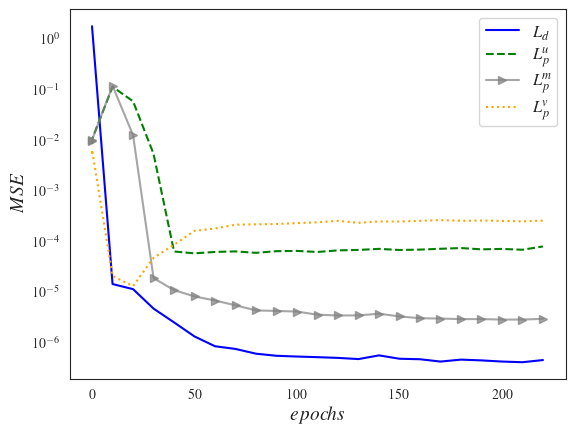

<Figure size 640x480 with 0 Axes>

In [5]:
# # Loss functions
#        output_file = open(self.dest + 'output.dat', 'a')
#        print(ep, f'{lu}', f'{lmomuf}', f'{lmomvf}', f'{lmassf}',
#              file=output_file)

plt.figure()
plt.semilogy(loss[0], loss[1] , label = '$L_d$'  , color = 'blue')
plt.semilogy(loss[0], loss[2] , label = '$L_p^{u}$' , color = 'green' , linestyle = '--')
plt.semilogy(loss[0], loss[-1] , label = '$L_p^{m}$' , color = 'grey', marker = '>', alpha=0.7)
plt.semilogy(loss[0], loss[3] , label = '$L_p^{v}$' , color = 'orange', linestyle = ':')

plt.xlabel('$epochs$', fontsize = 14)
plt.ylabel('$MSE$', fontsize = 14)
plt.legend(fontsize = 12)
plt.show()
plt.savefig(f'{fig_path}/loss.png')


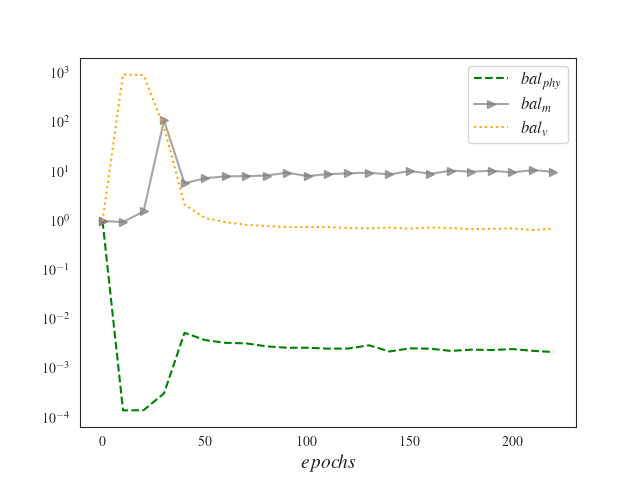

In [8]:
#print(ep, self.bal_phys.numpy(), self.bal_phys_m.numpy(), self.bal_phys_v.numpy(), file=output_file)
plt.figure()
plt.semilogy(bal[0], bal[1] , label = '$bal_{phy}$',  color = 'green' , linestyle = '--')
plt.semilogy(bal[0], bal[2] , label = '$bal_{m}$'  ,  color = 'grey', marker = '>', alpha=0.7)
plt.semilogy(bal[0], bal[3] , label = '$bal_{v}$'  , color = 'orange', linestyle = ':', )


plt.xlabel('$epochs$', fontsize = 14)
plt.legend(fontsize = 12)
plt.show()
plt.savefig(f'{fig_path}/balance.png')

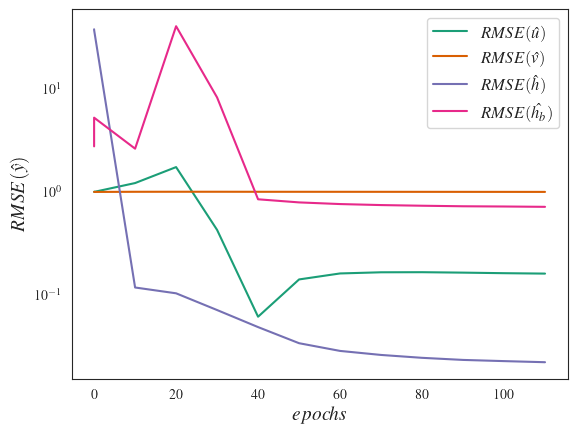

In [13]:
plt.figure()
plt.semilogy(val[0] , val[1] , label = '$RMSE(\hat{u})$' )
plt.semilogy(val[0] , val[2] , label = '$RMSE(\hat{v})$' )
plt.semilogy(val[0] , val[3] , label = '$RMSE(\hat{h})$')
plt.semilogy(val[0] , val[-1] , label = '$RMSE(\hat{h_b})$' )

plt.xlabel('$epochs$', fontsize = 14)
plt.ylabel('$RMSE(\hat{y})$', fontsize = 14)
plt.legend( fontsize = 12)
plt.savefig(f'{fig_path}/validation.png')


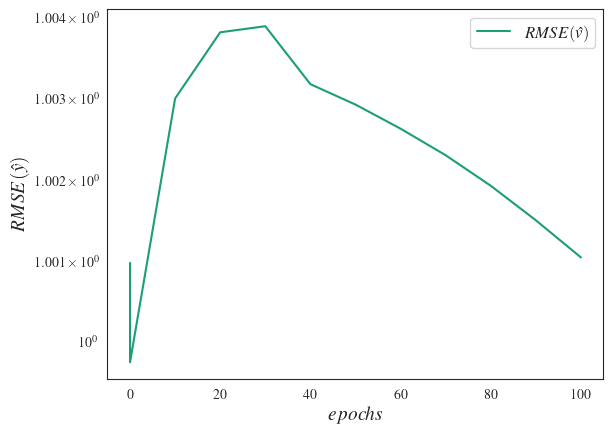

In [47]:
plt.figure(3)
plt.semilogy(val[0] , val[2] , label = '$RMSE(\hat{v})$' )

plt.xlabel('$epochs$', fontsize = 14)
plt.ylabel('$RMSE(\hat{y})$', fontsize = 14)
plt.legend( fontsize = 12)
plt.savefig(f'{fig_path}/validation_v.png')

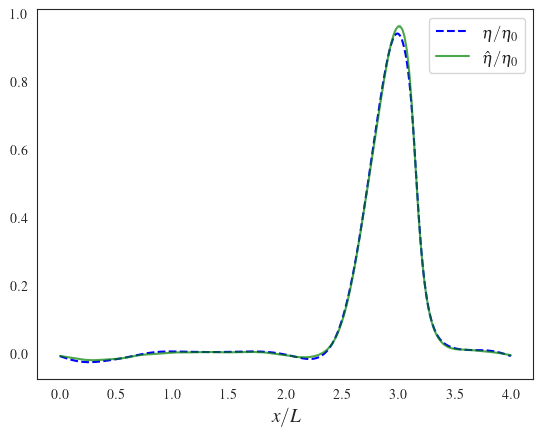

In [48]:
plt.figure()
plt.plot(domain ,ETA[:, 512] , label = r'$\eta/\eta_0$' ,  linestyle = '--' , color = 'blue')
plt.plot(domain , eta[:, 512] ,  label = r'$\hat{\eta}/\eta_0$' , alpha = 0.7 , color = 'green')
plt.xlabel('$x/L$', fontsize = 14)
plt.legend(fontsize = 12)
plt.savefig(f'{fig_path}/h_1D.png')

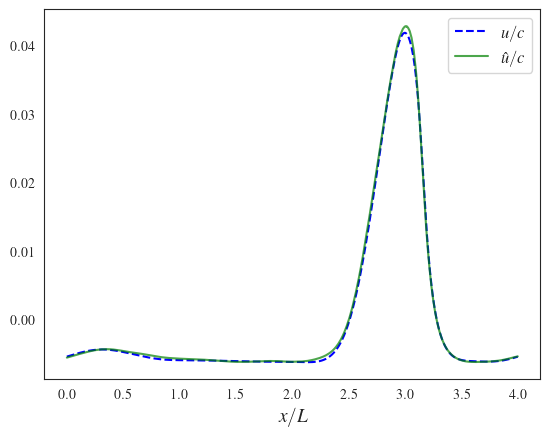

In [14]:
plt.figure()
plt.plot(domain , U[:, 512] , label = '$u/c$' ,  linestyle = '--' , color = 'blue')
plt.plot(domain , u[:, 512] ,  label = '$\hat{u}/c$' , alpha = 0.7 , color = 'green')
plt.xlabel('$x/L$', fontsize = 14)
plt.legend(fontsize = 12)
plt.savefig(f'{fig_path}/u_1D.png')


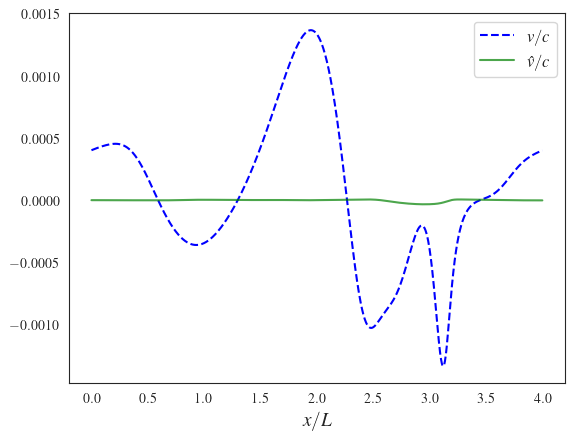

In [15]:
plt.figure()
plt.plot(domain ,V[:, 700] , label = '$v/c$' ,  linestyle = '--' , color = 'blue')
plt.plot(domain ,v[:, 700] ,  label = '$\hat{v}/c$' , alpha = 0.7 , color = 'green')
plt.xlabel('$x/L$', fontsize = 14)
plt.legend(fontsize = 12)
plt.savefig(f'{fig_path}/v_1D.png')

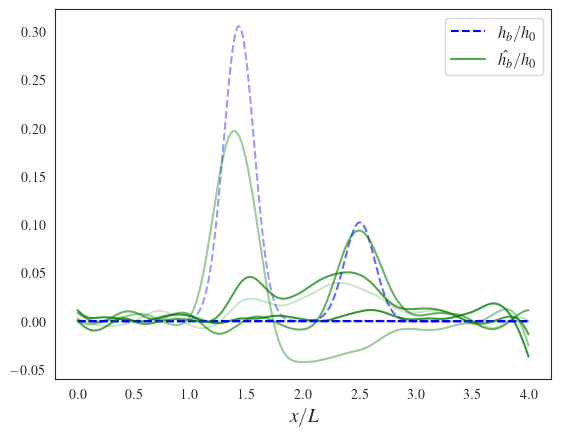

In [16]:
plt.figure()
for yy, alpha in zip(range(0,1024,200) , np.arange(0,1,0.2) ):
    plt.plot(domain ,HB[:, yy] ,   linestyle = '--' , alpha = alpha , color = 'blue')
    plt.plot(domain ,hb[:, yy] ,   alpha = alpha , color = 'green')

plt.plot(domain ,HB[:, 512] , label = '$h_b/h_0$' ,  linestyle = '--' , color = 'blue')
plt.plot(domain ,hb[:, 512] ,  label = '$\hat{h_b}/h_0$' , alpha = 0.7 , color = 'green')

plt.xlabel('$x/L$', fontsize = 14)
plt.legend(fontsize = 12)
plt.savefig(f'{fig_path}/hb_1D.png')

# 3d image diagram

/tmp/ipykernel_1091703/2364177668.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


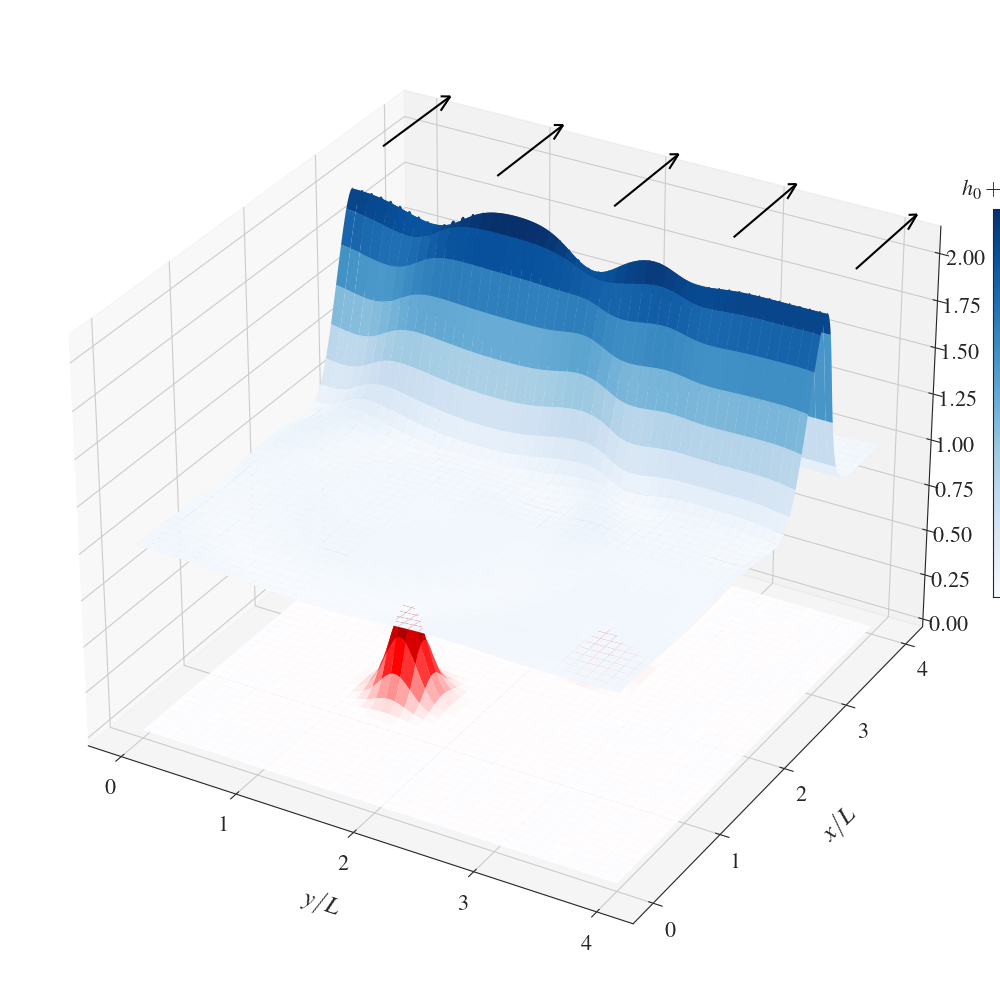

In [105]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


hf = plt.figure(figsize=(10, 10))
ha1 = hf.add_subplot(111, projection='3d')


# ----- Surfaces ----------------------------------------------------------
surf1 = ha1.plot_surface(X, Y, ETA+h0, cmap='Blues', edgecolor='grey',    linewidth=0.001 )

vmax_hat = np.max(np.abs(HB))
norm = TwoSlopeNorm(
    vmin=-vmax_hat,
    vcenter=0.0,
    vmax=vmax_hat
)
surf2 = ha1.plot_surface(X, Y, HB, cmap='seismic', norm=norm,edgecolor='none')

# ----- COLORBAR 1: for data1 (Blues) -------------------------------------
cax1 = inset_axes(
    ha1,
    width="3%",      # width of colorbar
    height="40%",    # height of colorbar
    loc='center right',
    # bbox_to_anchor=(0.05, 0.1, 1, 1),
    bbox_to_anchor=(0.04, 0.1, 1, 1),
    bbox_transform=ha1.transAxes,
    borderpad=0.1
)

cbar1 = hf.colorbar(surf1, cax=cax1, pad = 0.1)
# cbar1.set_label(r"$h_0 + \eta/\eta_0$", fontsize=16, rotation=0, labelpad=15)
cbar1.ax.set_title(r"$h_0 + \eta/\eta_0$", fontsize=16, pad=10)
cbar1.ax.tick_params(labelsize=14)

# ----- COLORBAR 2: for data2 (seismic) -----------------------------------
cax2 = inset_axes(
    ha1,
    width="3%",
    height="40%",
    loc='center right',
    # bbox_to_anchor=(0.05, 0.1, 1, 1),
    bbox_to_anchor=(0.14, 0.1, 1, 1),
    bbox_transform=ha1.transAxes,
    borderpad=0.1
)

cbar2 = hf.colorbar(surf2, cax=cax2, pad = 0.1)
# cbar2.set_label(r"$h_b/h_0$", fontsize=16, rotation=0, labelpad=15)
cbar2.ax.set_title(r"$h_b/h_0$", fontsize=16, pad=10)
cbar2.ax.tick_params(labelsize=14)

# ----- Axis labels & ticks -----------------------------------------------
ha1.set_xlabel("$y/L$", fontsize=18, labelpad=15)
ha1.set_ylabel("$x/L$", fontsize=18, labelpad=15)
ha1.tick_params(axis='both', which='major', labelsize=16)
ha1.tick_params(axis='z', which='major', labelsize=16)

# ----- Arrows -------------------------------------------------------------
x_annotate = domain[np.argmax(ref120[2][:, 512])] + 0.5
z_annotate = h0 + 1.1
y_coords = np.linspace(y.min(), y.max(), 5)

for y_annotate in y_coords:
    ha1.quiver(
        y_annotate, x_annotate, z_annotate,
        0, 1, 0,
        color='black', arrow_length_ratio=0.15,     zorder=1000

    )
# ----- Clean integer ticks (0,1,2,3,4) -----------------------------------
ticks = np.arange(0, 5, 1)

ha1.xaxis.set_major_locator(FixedLocator(ticks))
ha1.yaxis.set_major_locator(FixedLocator(ticks))

ha1.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ha1.yaxis.set_major_formatter(FormatStrFormatter('%d'))

plt.tight_layout()
plt.show()


In [106]:
# Save the figure without margins once it is the angle we want
plt.savefig(f'{fig_path}/h_hb_diagram_3d.pdf', bbox_inches='tight')

# hb 3D and 2D plots

## hb 3D plots

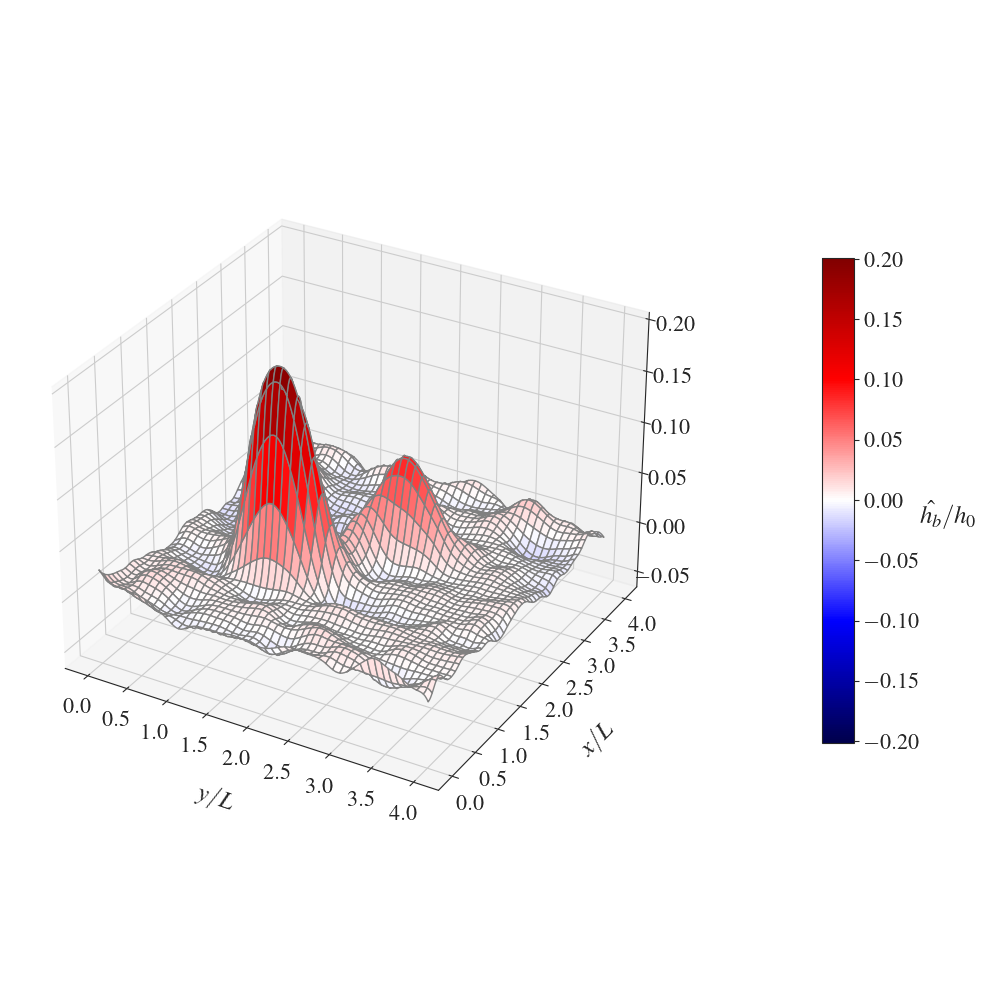

In [70]:
%matplotlib widget
hf = plt.figure(figsize=(10, 10))
ha1 = hf.add_subplot(111, projection='3d')

# -- Surface plot --------------------------------------------------------
'''norm = TwoSlopeNorm(
    vmin=np.min(hb),
    vcenter=0.0,
    vmax=np.max(hb)
)'''
vmax_hat = np.max(np.abs(hb))
norm = TwoSlopeNorm(
    vmin=-vmax_hat,
    vcenter=0.0,
    vmax=vmax_hat
)
surf = ha1.plot_surface(
    X, Y, hb,
    cmap= 'seismic',   # or ,'RdBu_r' 'bwr', 'coolwarm' # 'magma'
    norm=norm,
    edgecolor='grey'
)



# -- Colorbar ------------------------------------------------------------
cbar = hf.colorbar(
    surf,
    ax=ha1,
    shrink=0.5,     # makes the colorbar shorter (0.5 = half height)
    aspect=15,      # controls thickness (higher = thinner)
    pad=0.15        # distance between plot and colorbar
)
cbar.set_label(r"$\hat{h_b}/h_0$", fontsize=18, rotation=0, labelpad=20)
cbar.ax.tick_params(labelsize=16)  # colorbar tick labels



# -- Axes labels ---------------------------------------------------------
# ha1.set_zlabel("$\hat{h_b}$", fontsize=18)
ha1.set_xlabel("$y/L$", fontsize=18, labelpad=15 )
ha1.set_ylabel("$x/L$", fontsize=18, labelpad=15 )

# -- Tick label size -----------------------------------------------------
ha1.tick_params(axis='both', which='major', labelsize=16)
ha1.tick_params(axis='z', which='major', labelsize=16)



plt.tight_layout()
plt.show()

In [17]:

# Save the figure without margins once it is the angle we want
plt.savefig(f'{fig_path}/hb_3d.pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_74204/1258873131.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


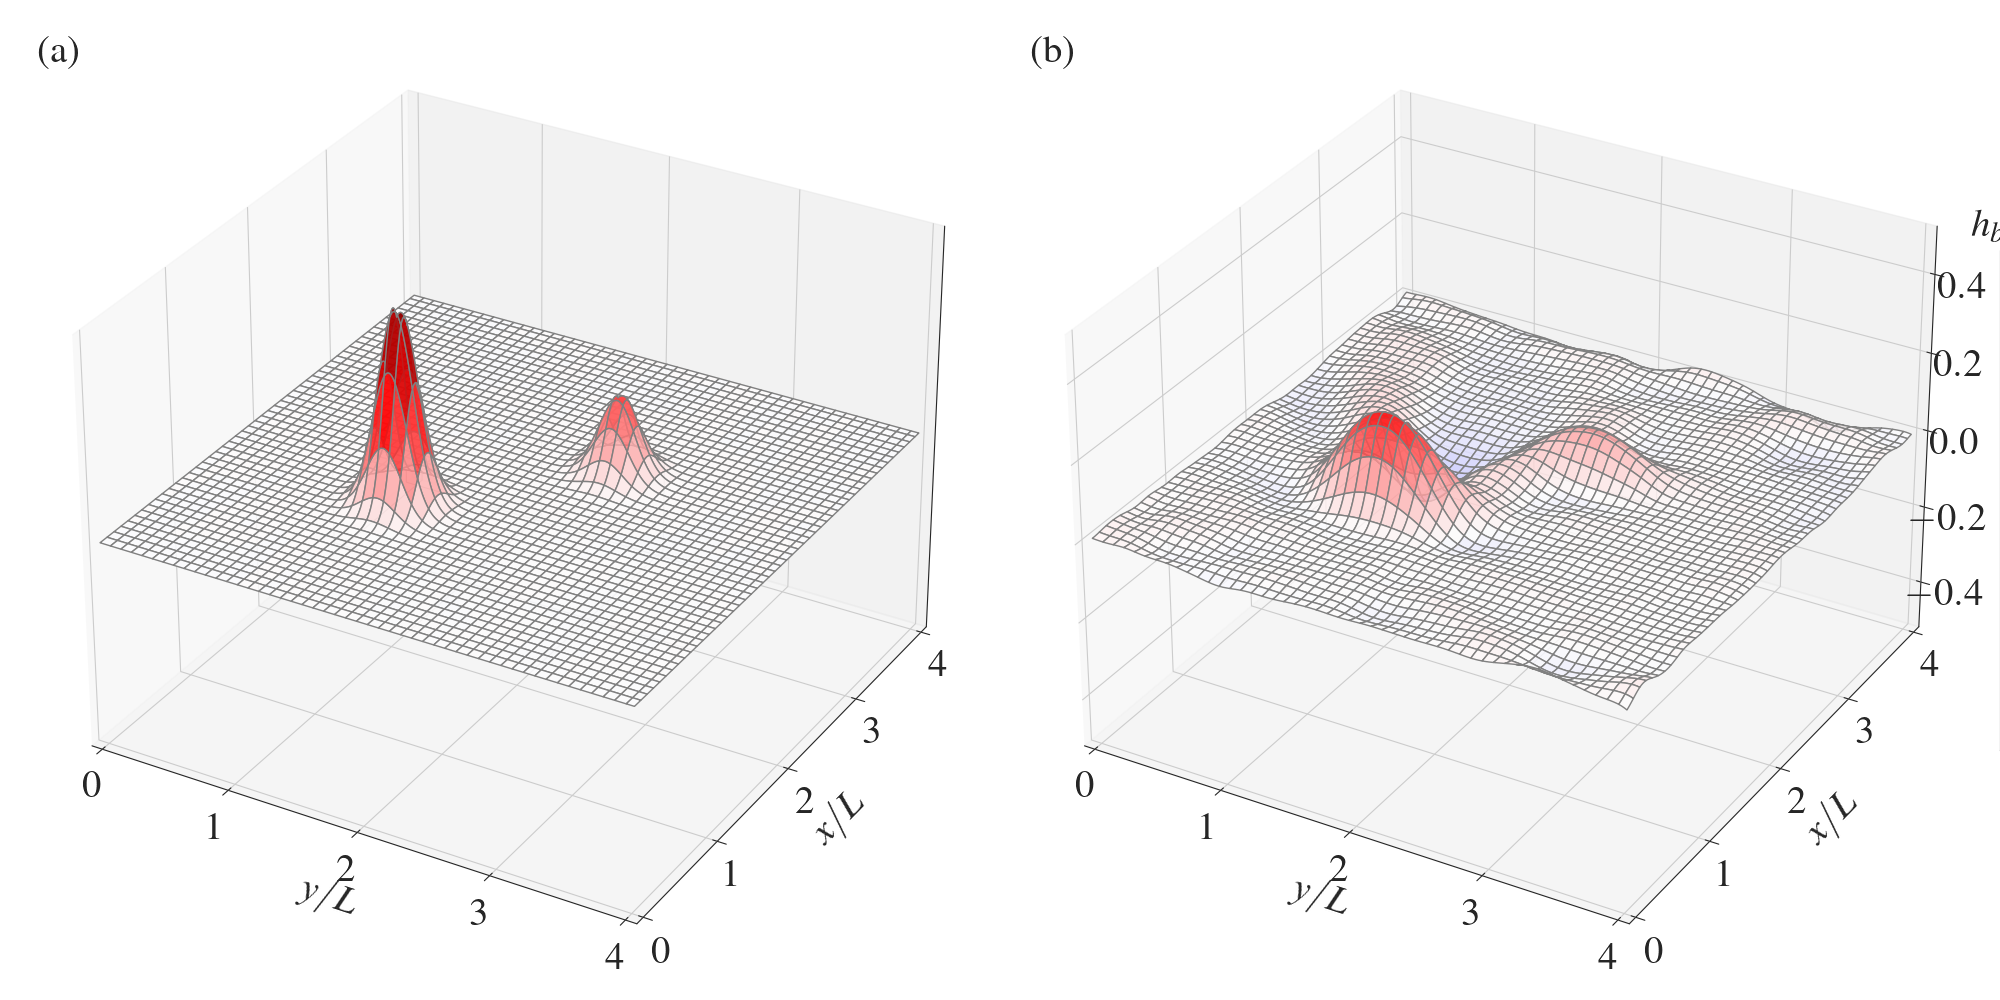

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# -- Figure with two side-by-side 3D subplots -----------------------------
hf = plt.figure(figsize=(20, 10))

ax1 = hf.add_subplot(122, projection="3d")# (121, projection="3d")
ax2 = hf.add_subplot(121, projection="3d")# (122, projection="3d")

# -- Shared normalization (single colorbar!) ------------------------------
vmax = max(np.max(np.abs(hb)), np.max(np.abs(HB)))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

# -- Left subplot: PINN ---------------------------------------------------
surf_hat = ax1.plot_surface(
    X, Y, hb,
    cmap="seismic",
    norm=norm,
    edgecolor="grey",
    alpha=0.8
)

# ax1.set_title(r"$PINN$", fontsize=18, pad=12)
ax1.set_xlabel("$y/L$", fontsize=28, labelpad=12)
ax1.set_ylabel("$x/L$", fontsize=28, labelpad=12)

# -- Right subplot: Ground Truth -----------------------------------------
surf_ref = ax2.plot_surface(
    X, Y, HB,
    cmap="seismic",
    norm=norm,
    edgecolor="grey",
    alpha=0.8
)

# ax2.set_title(r"$Ground$ $Truth$", fontsize=18, pad=12)
ax2.set_xlabel("$y/L$", fontsize=28, labelpad=12)
ax2.set_ylabel("$x/L$", fontsize=28, labelpad=12)

# -- 1) Shared axis limits -----------------------------------------------
# y-axis (and x/z if desired)
ymin, ymax = Y.min(), Y.max()
xmin, xmax = X.min(), X.max()
zmin, zmax = -vmax, vmax

for ax in (ax1, ax2):
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    ax.tick_params(axis="both", which="major", labelsize=28)
    ax.tick_params(axis="z", which="major", labelsize=28)

# -- Manually place colorbar axis (left of subplot b) --------------------
cax = hf.add_axes([1., 0.25, 0.015, 0.5])
# [left, bottom, width, height] in figure coordinates
cbar = hf.colorbar(
    surf_hat,     # any surface with the shared norm
    cax=cax
)

# cbar.set_label(r"$h_b/h_0$", fontsize=24, rotation=0, labelpad=25)
cbar.ax.set_title(r"$h_b/h_0$", fontsize=28, pad=10)
cbar.ax.tick_params(labelsize=28)

# -- 3) Panel labels (a), (b) ---------------------------------------------
ax1.text2D(
    0.02, 0.95, r"(b)",
    transform=ax1.transAxes,
    fontsize=28,
    fontweight="bold"
)

ax2.text2D(
    0.02, 0.95, r"(a)",
    transform=ax2.transAxes,
    fontsize=28,
    fontweight="bold"
)

from matplotlib.ticker import FixedLocator, FormatStrFormatter

ticks = np.arange(0, 5, 1)  # [0, 1, 2, 3, 4]

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(FixedLocator(ticks))
    ax.yaxis.set_major_locator(FixedLocator(ticks))

    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))

ax2.zaxis.set_major_locator(plt.NullLocator())

plt.tight_layout()
plt.show()


In [7]:

# Save the figure without margins once it is the angle we want
plt.savefig(f'{fig_path}/hb_3d_with_ref.pdf', bbox_inches='tight')

## hb 2D plots 

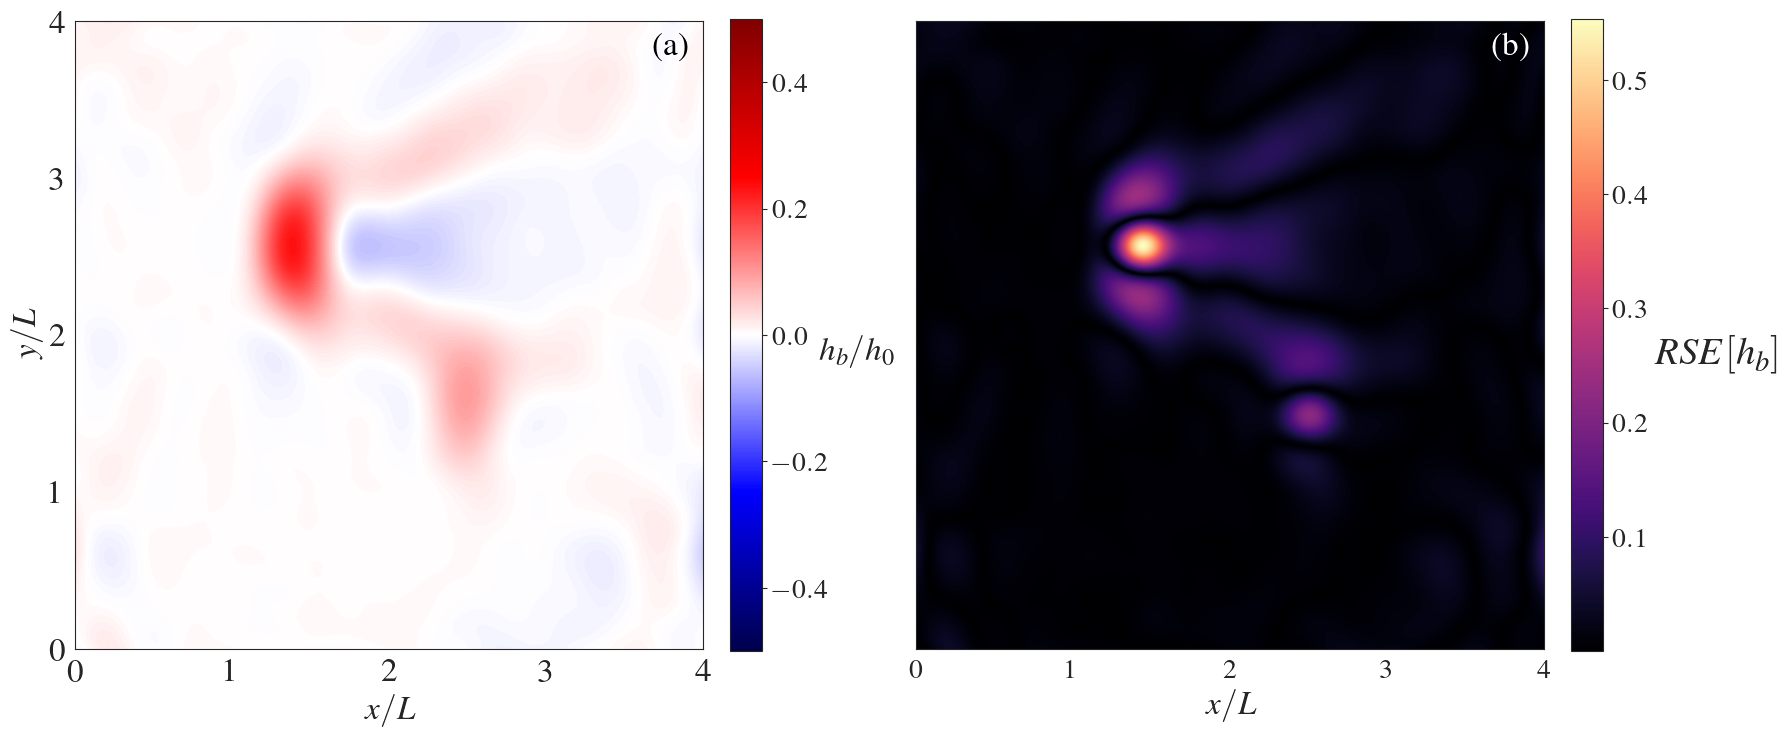

In [9]:
%matplotlib inline
# -------------------------------------------------
# Figure and axes
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# ==================================================
# (a) hb implot
# ==================================================
ax = axes[0]

# -- Shared normalization (single colorbar!) ------------------------------
vmax = max(np.max(np.abs(hb)), np.max(np.abs(HB)))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

f1 = ax.imshow(
    np.transpose(hb),
    cmap='seismic',
    norm=norm,
    extent=[domain.min(), domain.max(), domain.min(), domain.max()]
)

ax.set_xlabel('$x/L$', fontsize=24)
ax.set_ylabel('$y/L$', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)

ax.set_xlim(domain.min(), domain.max())
ax.set_ylim(domain.min(), domain.max())
ax.set_aspect('equal')

ticks = np.linspace(domain.min(), domain.max(), 5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# Colorbar (a)
cbar1 = fig.colorbar(
    f1,
    ax=ax,
    fraction=0.046,
    pad=0.04
)
cbar1.set_label(r"$h_b/h_0$", fontsize=24, rotation=0, labelpad=20)
cbar1.ax.tick_params(labelsize=20)

# (a) label — upper right
ax.text(
    0.98, 0.98, "(a)",
    transform=ax.transAxes,
    fontsize=24,
    color="black",
    va="top", ha="right"
)


# ==================================================
# (b) error implot
# ==================================================
ax = axes[1]

#RSE =  $\frac{\sqrt{(h_b - \hat{h_b})^2}}{\int\int(\sqrt{h_b^2})dx dy}$
f2 = ax.imshow(
    np.transpose(RSE_hb(hb,HB, X=domain, Y=domain, normalization = 'max')),
    cmap='magma',
    extent=[domain.min(), domain.max(), domain.min(), domain.max()]
)

ax.set_xlabel('$x/L$', fontsize=24)
# ax.set_ylabel('$y/L$', fontsize=20)
# X axis: keep ticks + formatting
ax.tick_params(axis='x', which='major', labelsize=20)
# Y axis: remove ticks and labels
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Enforce identical axes and ticks
ax.set_xlim(domain.min(), domain.max())
ax.set_ylim(domain.min(), domain.max())
ax.set_aspect('equal')

ticks = np.linspace(domain.min(), domain.max(), 5)  # e.g. [0,1,2,3,4]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# Colorbar (b)
cbar2 = fig.colorbar(
    f2,
    ax=ax,
    fraction=0.046,
    pad=0.04
)
#RSE =  $\frac{\sqrt{(h_b - \hat{h_b})^2}}{\int\int(\sqrt{h_b^2})dx dy}$
cbar2.set_label(
    r"$RSE[h_b]$",
    fontsize=28,
    rotation=0,
    labelpad=50
)
cbar2.ax.tick_params(labelsize=20)

# (b) label — upper right
ax.text(
    0.98, 0.98, "(b)",
    transform=ax.transAxes,
    fontsize=24,
    color="white",
    va="top", ha="right"
)


# --------------------------------------------------
# Layout & save
# --------------------------------------------------
plt.tight_layout()
plt.savefig(f"{fig_path}/hb_hb_error_implot.pdf")
plt.show()


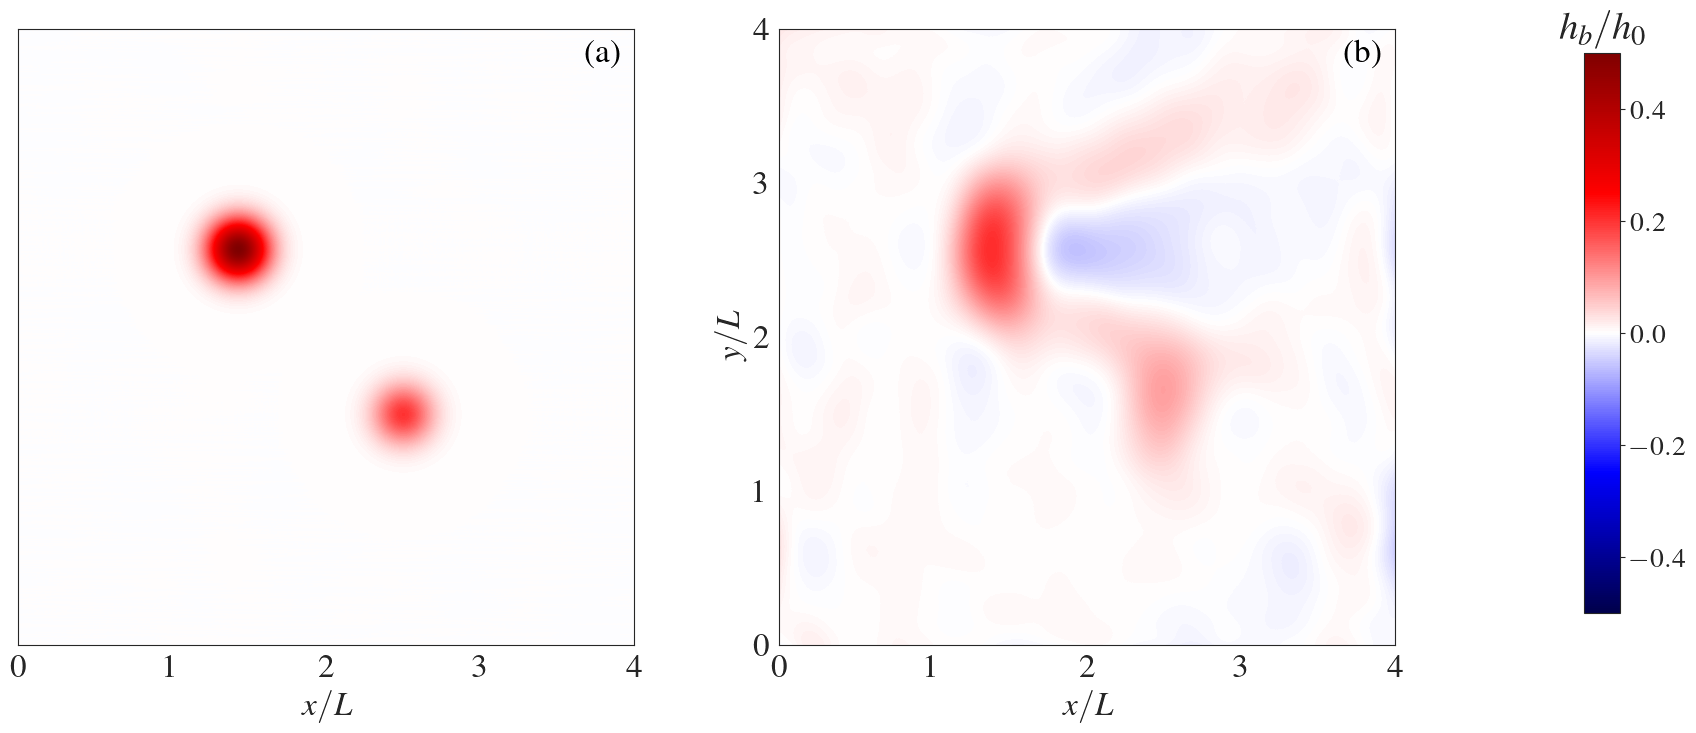

In [58]:
%matplotlib inline
# -------------------------------------------------
# Figure and axes
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# ==================================================
# (a) hb implot
# ==================================================
ax = axes[1]

# -- Shared normalization (single colorbar!) ------------------------------
vmax = max(np.max(np.abs(hb)), np.max(np.abs(HB)))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

f1 = ax.imshow(
    np.transpose(hb),
    cmap='seismic',
    norm=norm,
    extent=[domain.min(), domain.max(), domain.min(), domain.max()]
)

ax.set_xlabel('$x/L$', fontsize=24)
ax.set_ylabel('$y/L$', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)

ax.set_xlim(domain.min(), domain.max())
ax.set_ylim(domain.min(), domain.max())
ax.set_aspect('equal')

ticks = np.linspace(domain.min(), domain.max(), 5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)


# (a) label — upper right
ax.text(
    0.98, 0.98, "(b)",
    transform=ax.transAxes,
    fontsize=24,
    color="black",
    va="top", ha="right"
)


# ==================================================
# (b) true hb implot
# ==================================================
ax = axes[0]

f2 = ax.imshow(
    np.transpose(HB),
    cmap='seismic',
    norm=norm,
    extent=[domain.min(), domain.max(), domain.min(), domain.max()]
)

ax.set_xlabel('$x/L$', fontsize=24)
# ax.set_ylabel('$y/L$', fontsize=20)
# X axis: keep ticks + formatting
ax.tick_params(axis='x', which='major', labelsize=24)
# Y axis: remove ticks and labels
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Enforce identical axes and ticks
ax.set_xlim(domain.min(), domain.max())
ax.set_ylim(domain.min(), domain.max())
ax.set_aspect('equal')

ticks = np.linspace(domain.min(), domain.max(), 5)  # e.g. [0,1,2,3,4]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# -- Shared colorbar (far right of subplot b) -----------------------------
cax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
# [left, bottom, width, height] in figure coordinates

cbar = fig.colorbar(
    f1,    # or f2 — both share the same norm and cmap
    cax=cax
)

# cbar.set_label(r"$h_b/h_0$", fontsize=28, rotation=0, labelpad=25)
cbar.ax.set_title(r"$h_b/h_0$", fontsize=28, pad=10)

cbar.ax.tick_params(labelsize=20)


# (b) label — upper right
ax.text(
    0.98, 0.98, "(a)",
    transform=ax.transAxes,
    fontsize=24,
    color="black",
    va="top", ha="right"
)


# --------------------------------------------------
# Layout & save
# --------------------------------------------------
# plt.tight_layout()
plt.savefig(f"{fig_path}/hb_hb_ref_implot.pdf",
    bbox_inches="tight")
plt.show()

# u 3D and 2D plots

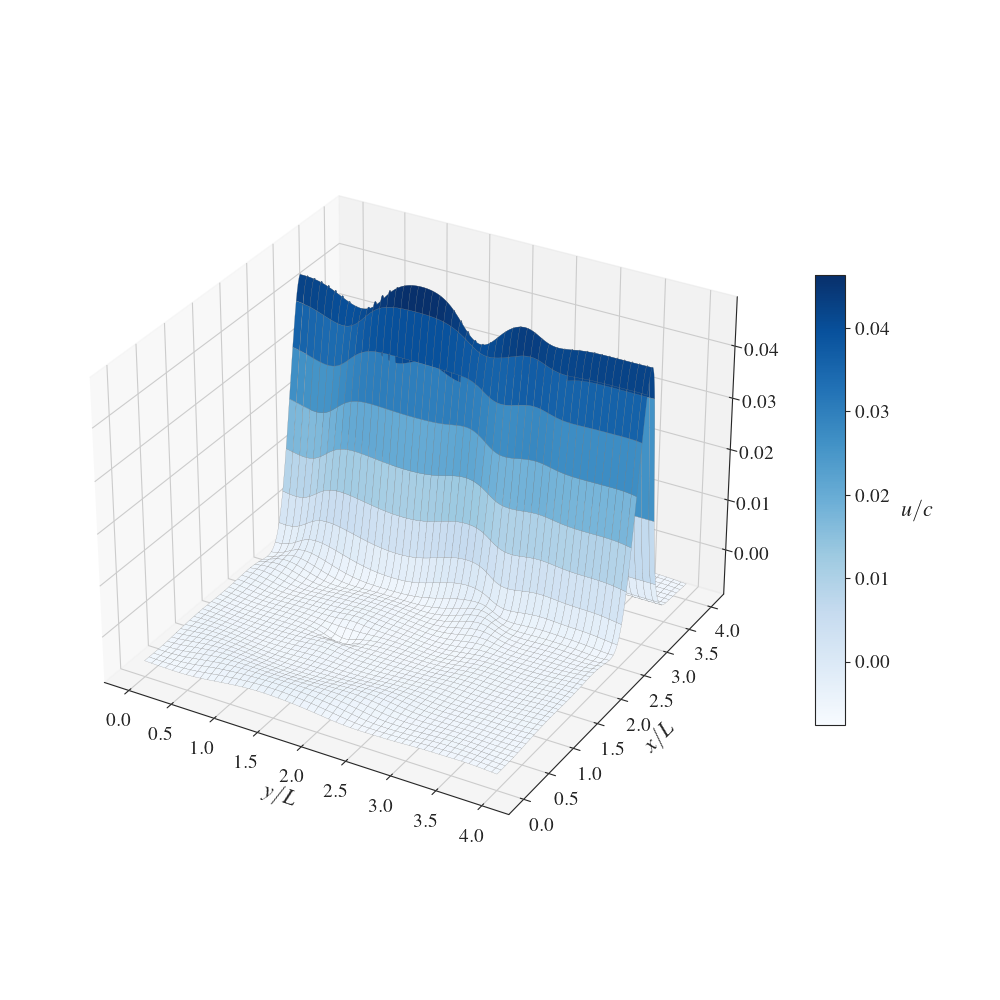

In [52]:
%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

hf = plt.figure(figsize=(10, 10))
ha1 = hf.add_subplot(111, projection='3d')


# --- Surface --------------------------------------------------------------
surf = ha1.plot_surface(
    X, Y, U,
    cmap='Blues',
    edgecolor='grey',
    linewidth=0.15     # thinner edges
)

# --- Colorbar (small, right side, horizontal label) -----------------------
cbar = hf.colorbar(
    surf,
    ax=ha1,
    shrink=0.5,     # makes the colorbar shorter (0.5 = half height)
    aspect=15,      # controls thickness (higher = thinner)
    pad=0.05        # distance between plot and colorbar
)

cbar.set_label("$u/c$", fontsize=16, rotation=0, labelpad=20)
cbar.ax.tick_params(labelsize=14)

# --- Labels ---------------------------------------------------------------
ha1.set_xlabel("$y/L$", fontsize=16)
ha1.set_ylabel("$x/L$", fontsize=16)
ha1.tick_params(axis='both', labelsize=14)
ha1.tick_params(axis='z', labelsize=14)

# Layout
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

plt.show()


In [ ]:
plt.savefig(f'{fig_path}/u_3d.png', bbox_inches='tight')

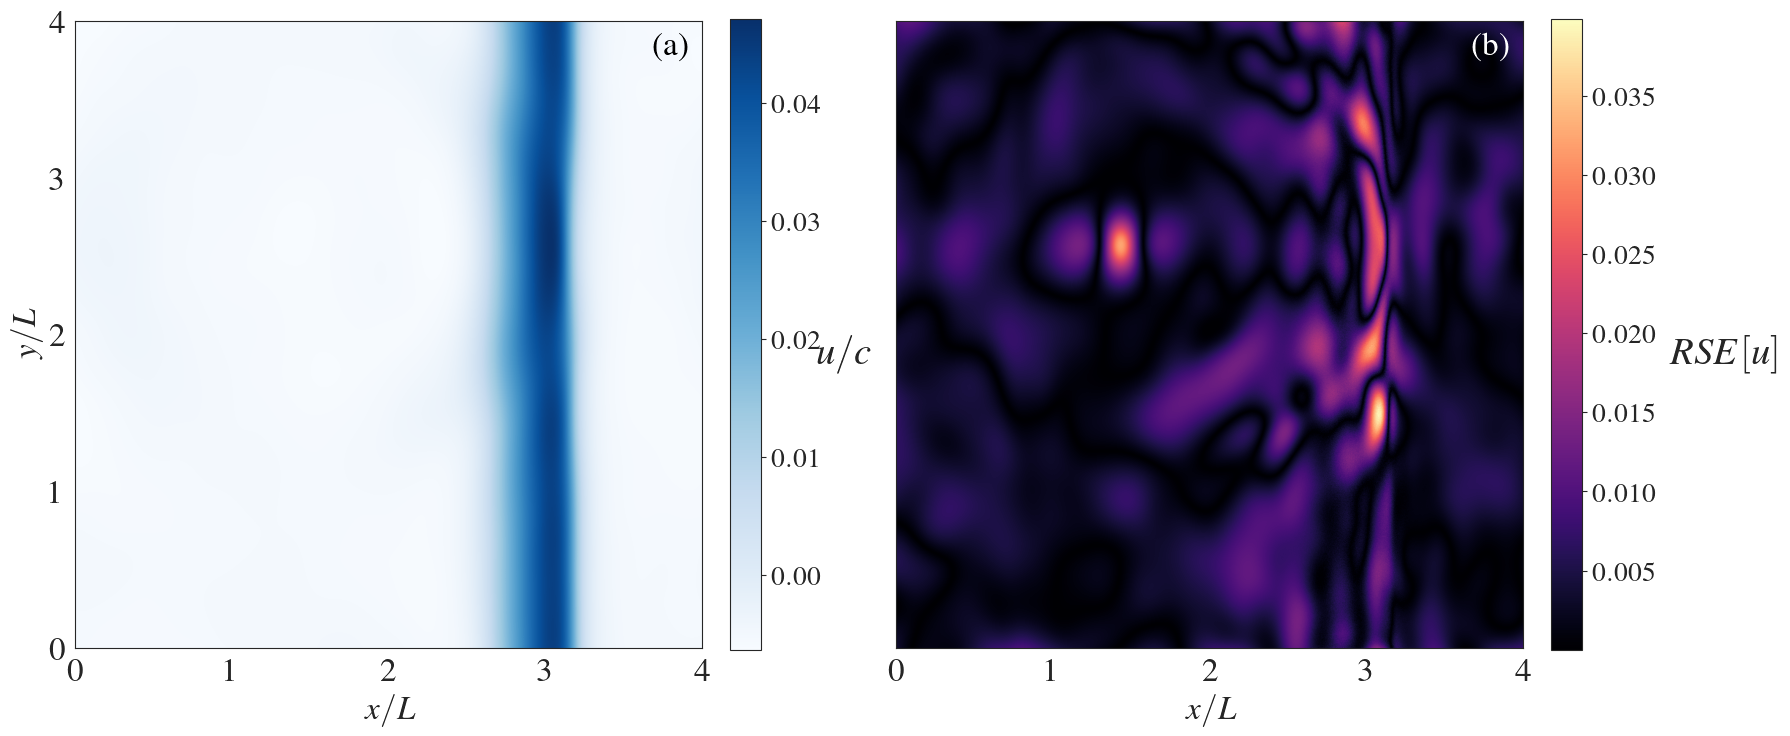

In [45]:
%matplotlib inline
# --------------------------------------------------
# Figure and axes
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# ==================================================
# (a) u field (prediction)
# ==================================================
ax = axes[0]

f1 = ax.imshow(
    np.transpose(u),
    cmap='Blues',
    extent=[domain.min(), domain.max(),
            domain.min(), domain.max()]
)

ax.set_xlabel('$x/L$', fontsize=24)
ax.set_ylabel('$y/L$', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
# Enforce identical axes and ticks
ax.set_xlim(domain.min(), domain.max())
ax.set_ylim(domain.min(), domain.max())
ax.set_aspect('equal')

ticks = np.linspace(domain.min(), domain.max(), 5)  # e.g. [0,1,2,3,4]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# Colorbar (a)
cbar1 = fig.colorbar(
    f1,
    ax=ax,
    fraction=0.046,
    pad=0.04
)
cbar1.set_label(r"$u/c$", fontsize=28, rotation=0, labelpad=18)
cbar1.ax.tick_params(labelsize=20)
# (a) label — upper right
ax.text(
    0.98, 0.98, "(a)",
    transform=ax.transAxes,
    fontsize=24,
    color="black",
    va="top", ha="right"
)

# ==================================================
# (b) u relative squared error
# ==================================================
ax = axes[1]

f2 = ax.imshow(
    np.transpose(RSE_u(u,U, X=domain, Y=domain, tts=None, normalization = 'max')),
    cmap='magma',
    extent=[domain.min(), domain.max(),
            domain.min(), domain.max()]
)

ax.set_xlabel('$x/L$', fontsize=24)
ax.set_xlabel('$x/L$', fontsize=24)
# ax.set_ylabel('$y/L$', fontsize=20)
# X axis: keep ticks + formatting
ax.tick_params(axis='x', which='major', labelsize=24)
# Y axis: remove ticks and labels
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Enforce identical axes and ticks
ax.set_xlim(domain.min(), domain.max())
ax.set_ylim(domain.min(), domain.max())
ax.set_aspect('equal')

ticks = np.linspace(domain.min(), domain.max(), 5)  # e.g. [0,1,2,3,4]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# Colorbar (b)
cbar2 = fig.colorbar(
    f2,
    ax=ax,
    fraction=0.046,
    pad=0.04
)
#\frac{\sqrt{(u - \hat{u})^2}}{\max(u)}
cbar2.set_label(
    r"$RSE[u]$",
    fontsize=28,
    rotation=0,
    labelpad=50
)
cbar2.ax.tick_params(labelsize=20)

# (b) label — upper right
ax.text(
    0.98, 0.98, "(b)",
    transform=ax.transAxes,
    fontsize=24,
    color="white",
    va="top", ha="right"
)


# --------------------------------------------------
# Layout & save
# --------------------------------------------------
plt.tight_layout()
plt.savefig(f"{fig_path}/u_uerror_implot.pdf")
plt.show()

# v 3D and 2D plots

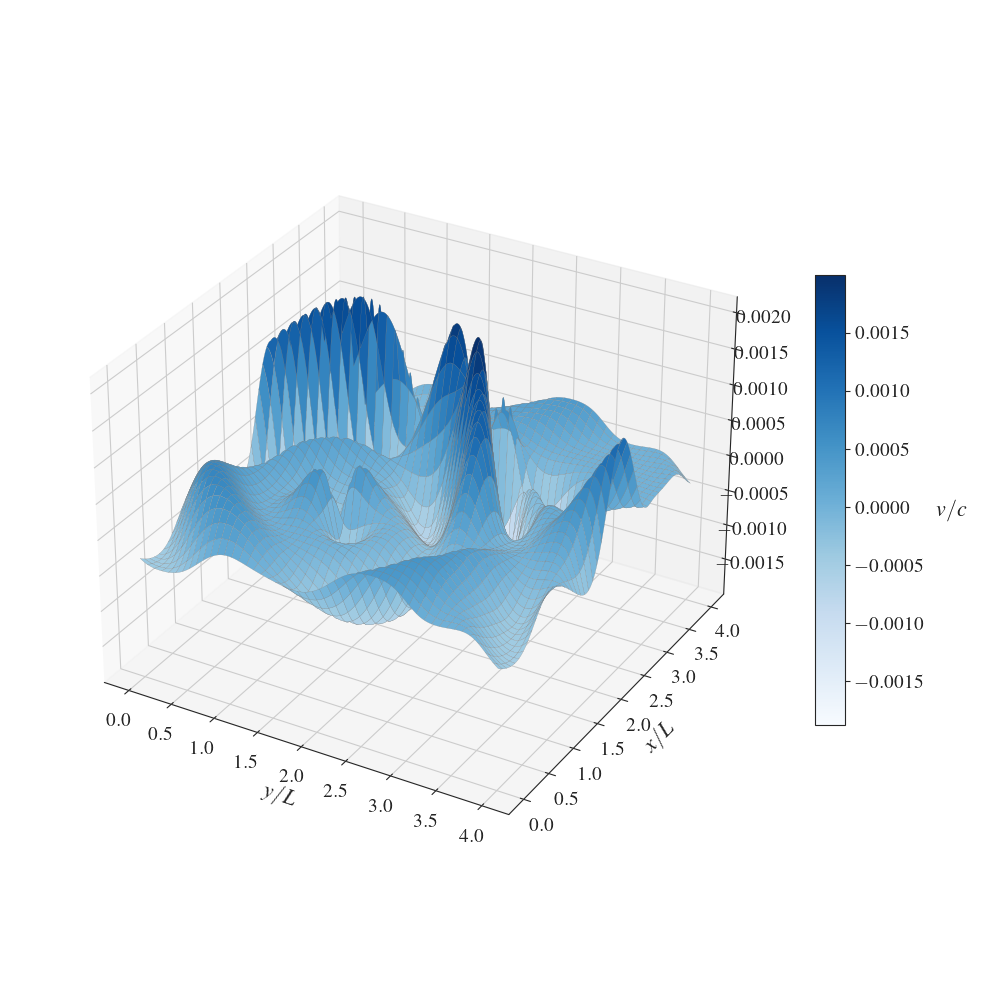

In [49]:
# error 3d graph for hb
# Restore the original style settings
# mpl.rcParams.update(original_rc_params)

%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D

hf = plt.figure(figsize=(10, 10))
ha1 = hf.add_subplot(111, projection='3d')


# --- Surface --------------------------------------------------------------
surf = ha1.plot_surface(
    X, Y, V,
    cmap='Blues',
    edgecolor='grey',
    linewidth=0.15     # thinner edges
)

# --- Colorbar (small, right side, horizontal label) -----------------------
cbar = hf.colorbar(
    surf,
    ax=ha1,
    shrink=0.5,     # makes the colorbar shorter (0.5 = half height)
    aspect=15,      # controls thickness (higher = thinner)
    pad=0.05        # distance between plot and colorbar
)

cbar.set_label("$v/c$", fontsize=16, rotation=0, labelpad=20)
cbar.ax.tick_params(labelsize=14)

# --- Labels ---------------------------------------------------------------
ha1.set_xlabel("$y/L$", fontsize=16)
ha1.set_ylabel("$x/L$", fontsize=16)
ha1.tick_params(axis='both', labelsize=14)
ha1.tick_params(axis='z', labelsize=14)

# Layout
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

plt.show()


In [ ]:
plt.savefig(f'{fig_path}/vy_3d_{particular_path}.png', bbox_inches='tight')

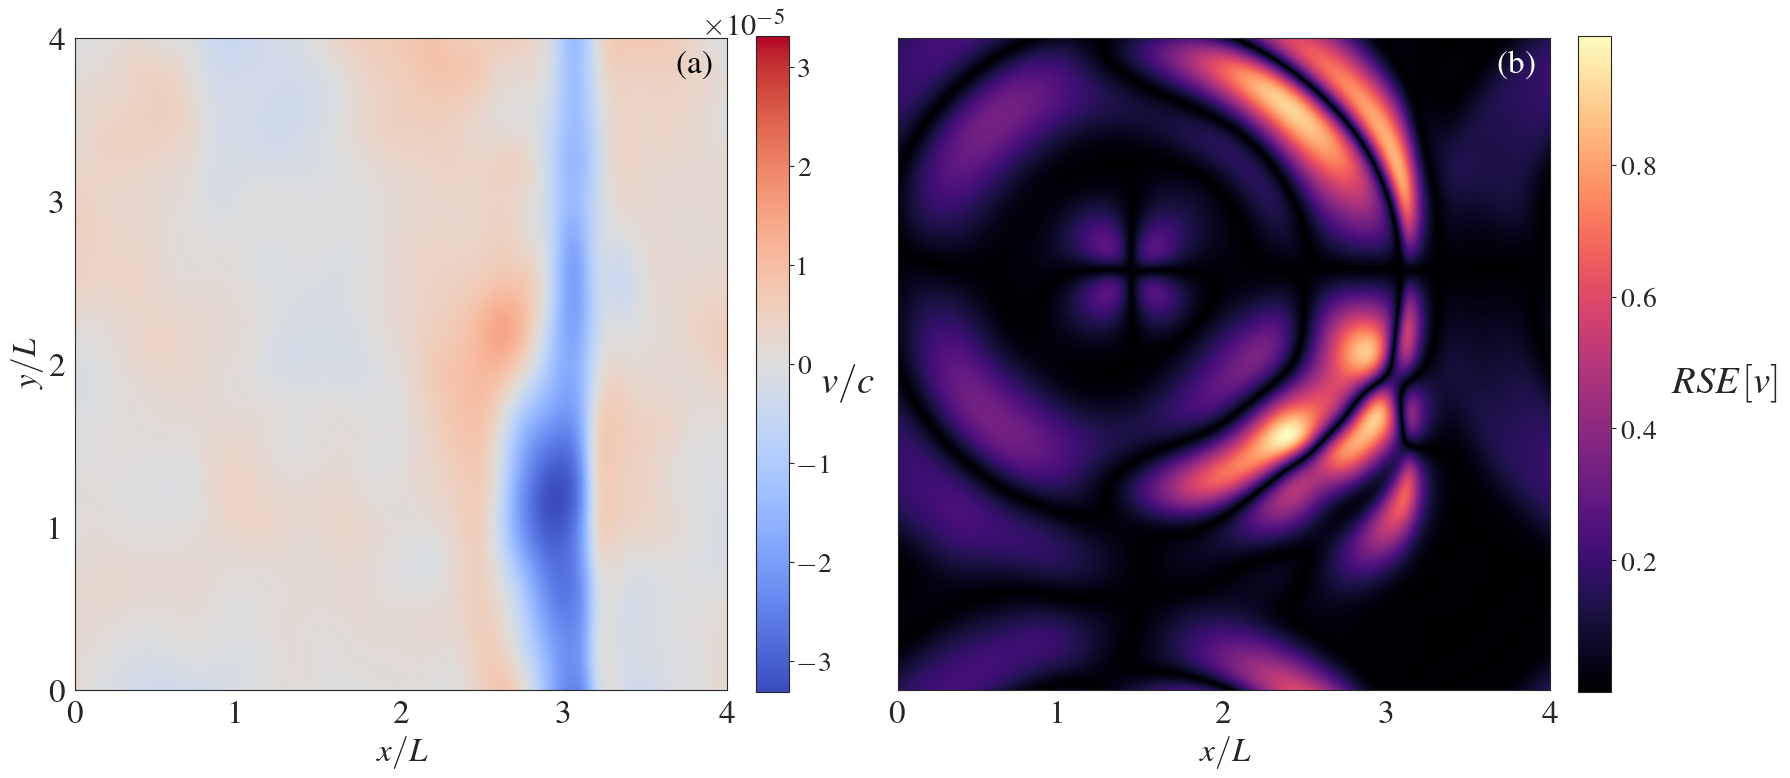

In [46]:
%matplotlib inline
# --------------------------------------------------
# Figure and axes
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# ==================================================
# (a) v field (prediction)
# ==================================================
ax = axes[0]

# Plot the image
vmax_hat = np.max(np.abs(v))
norm = TwoSlopeNorm(
    vmin=-vmax_hat,
    vcenter=0.0,
    vmax=vmax_hat
)

f1 = ax.imshow(
    np.transpose(v),
    cmap='coolwarm',
    norm=norm,
    extent=[domain.min(), domain.max(),
            domain.min(), domain.max()]
)

ax.set_xlabel('$x/L$', fontsize=24)
ax.set_ylabel('$y/L$', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)

# Colorbar (a)
cbar1 = fig.colorbar(
    f1,
    ax=ax,
    fraction=0.046,
    pad=0.04
)
cbar1.set_label(r"$v/c$", fontsize=28, rotation=0, labelpad=10)
cbar1.ax.tick_params(labelsize=20)
# After cbar1 is created
offset_text = cbar1.ax.yaxis.get_offset_text()
offset_text.set_fontsize(22)   # or 22–24 to match your style


# Enforce identical axes and ticks
ax.set_xlim(domain.min(), domain.max())
ax.set_ylim(domain.min(), domain.max())
ax.set_aspect('equal')

ticks = np.linspace(domain.min(), domain.max(), 5)  # e.g. [0,1,2,3,4]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# (a) label — upper right
ax.text(
    0.98, 0.98, "(a)",
    transform=ax.transAxes,
    fontsize=24,
    color="black",
    va="top", ha="right"
)

# ==================================================
# (b) v relative squared error
# ==================================================
ax = axes[1]

f2 = ax.imshow(
    np.transpose(RSE_u(v,V, X=domain, Y=domain, tts=None, normalization = 'max')),
    cmap='magma',
    extent=[domain.min(), domain.max(),
            domain.min(), domain.max()]
)

ax.set_xlabel('$x/L$', fontsize=24)
ax.set_xlabel('$x/L$', fontsize=24)
# ax.set_ylabel('$y/L$', fontsize=20)
# X axis: keep ticks + formatting
ax.tick_params(axis='x', which='major', labelsize=24)
# Y axis: remove ticks and labels
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Enforce identical axes and ticks
ax.set_xlim(domain.min(), domain.max())
ax.set_ylim(domain.min(), domain.max())
ax.set_aspect('equal')

ticks = np.linspace(domain.min(), domain.max(), 5)  # e.g. [0,1,2,3,4]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# Colorbar (b)
cbar2 = fig.colorbar(
    f2,
    ax=ax,
    fraction=0.046,
    pad=0.04
)
# \frac{\sqrt{(v - \hat{v})^2}}{\max(v)}
cbar2.set_label(
    r"$RSE[v]$",
    fontsize=28,
    rotation=0,
    labelpad=50
)
cbar2.ax.tick_params(labelsize=20)
# After cbar2 is created
offset_text = cbar2.ax.yaxis.get_offset_text()
offset_text.set_fontsize(20)   # or 22–24 to match your style


# (b) label — upper right
ax.text(
    0.98, 0.98, "(b)",
    transform=ax.transAxes,
    fontsize=24,
    color="white",
    va="top", ha="right"
)


# --------------------------------------------------
# Layout & save
# --------------------------------------------------
plt.tight_layout()
plt.savefig(f"{fig_path}/v_verror_implot.pdf")


# eta 2D plots

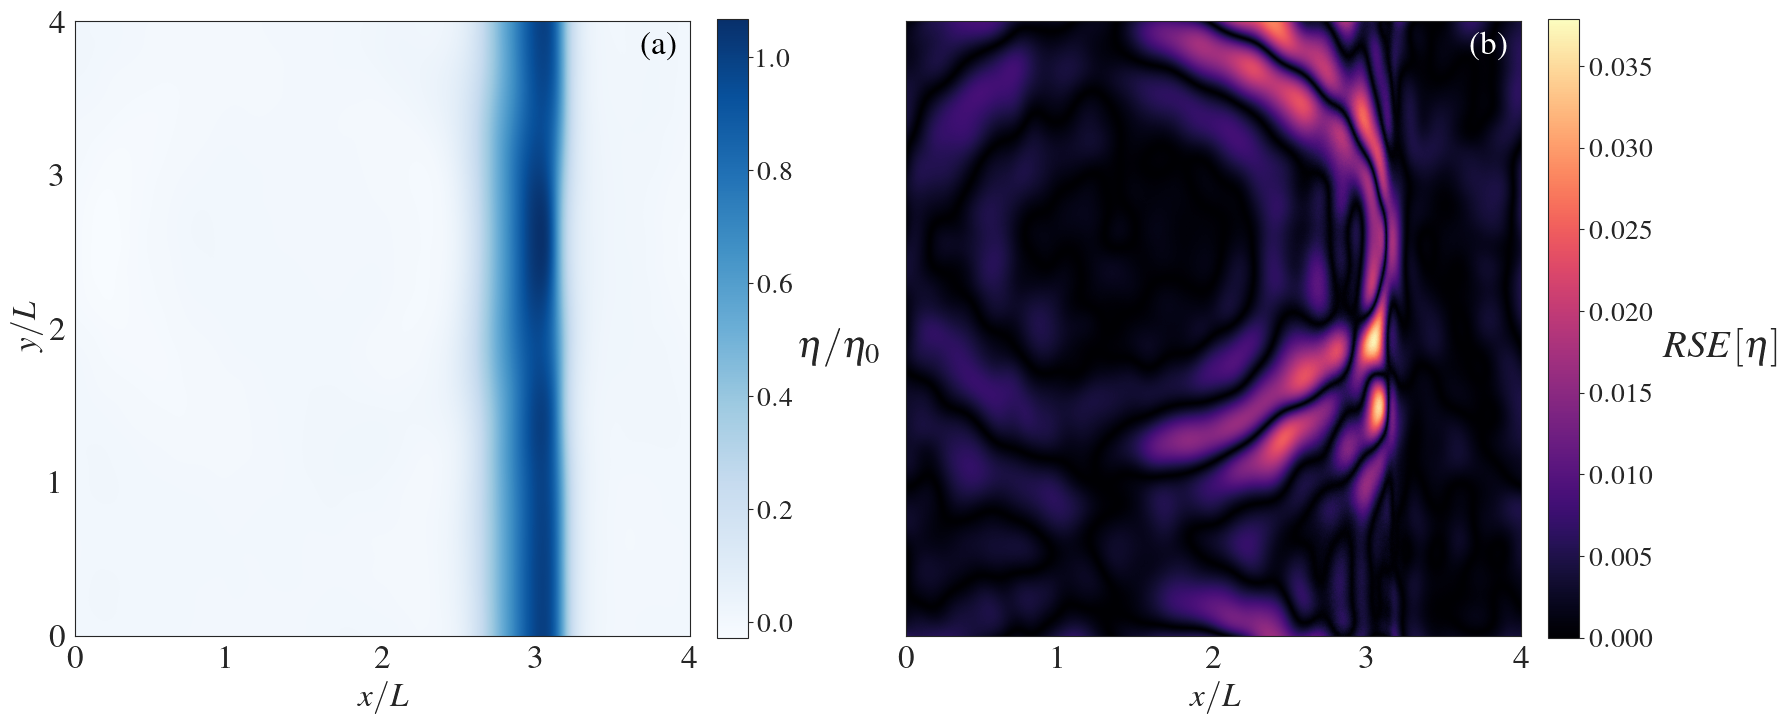

In [47]:
%matplotlib inline
# --------------------------------------------------
# Figure and axes
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# ==================================================
# (a) eta field (prediction)
# ==================================================
ax = axes[0]

# Plot the image
vmax_hat = np.max(np.abs(eta))
norm = TwoSlopeNorm(
    vmin=-vmax_hat,
    vcenter=0.0,
    vmax=vmax_hat
)
f1 = ax.imshow(
    np.transpose(eta),
    cmap='Blues',
    # norm=norm,
    extent=[domain.min(), domain.max(),
            domain.min(), domain.max()]
)

ax.set_xlabel('$x/L$', fontsize=24)
ax.set_ylabel('$y/L$', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)

# Colorbar (a)
cbar1 = fig.colorbar(
    f1,
    ax=ax,
    fraction=0.046,
    pad=0.04
)
cbar1.set_label(r"$\eta/\eta_0$", fontsize=28, rotation=0, labelpad=35)
cbar1.ax.tick_params(labelsize=20)
# Enforce identical axes and ticks
ax.set_xlim(domain.min(), domain.max())
ax.set_ylim(domain.min(), domain.max())
ax.set_aspect('equal')

ticks = np.linspace(domain.min(), domain.max(), 5)  # e.g. [0,1,2,3,4]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# (a) label — upper right
ax.text(
    0.98, 0.98, "(a)",
    transform=ax.transAxes,
    fontsize=24,
    color="black",
    va="top", ha="right"
)

# ==================================================
# (b) v relative squared error
# ==================================================
ax = axes[1]

f2 = ax.imshow(
    np.transpose(RSE_u(eta,ETA  , X=domain, Y=domain, tts=None, normalization = 'max')),
    cmap='magma',
    extent=[domain.min(), domain.max(),
            domain.min(), domain.max()]
)

ax.set_xlabel('$x/L$', fontsize=24)
ax.set_xlabel('$x/L$', fontsize=24)
# ax.set_ylabel('$y/L$', fontsize=20)
# X axis: keep ticks + formatting
ax.tick_params(axis='x', which='major', labelsize=24)
# Y axis: remove ticks and labels
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)


# Enforce identical axes and ticks
ax.set_xlim(domain.min(), domain.max())
ax.set_ylim(domain.min(), domain.max())
ax.set_aspect('equal')

ticks = np.linspace(domain.min(), domain.max(), 5)  # e.g. [0,1,2,3,4]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# Colorbar (b)
cbar2 = fig.colorbar(
    f2,
    ax=ax,
    fraction=0.046,
    pad=0.04
)
# \frac{\sqrt{(\eta - \hat{\eta})^2}}{\max(\eta)}
cbar2.set_label(
    r"$RSE[\eta]$",
    fontsize=28,
    rotation=0,
    labelpad=50
)
cbar2.ax.tick_params(labelsize=20)

# (b) label — upper right
ax.text(
    0.98, 0.98, "(b)",
    transform=ax.transAxes,
    fontsize=24,
    color="white",
    va="top", ha="right"
)


# --------------------------------------------------
# Layout & save
# --------------------------------------------------
plt.tight_layout()
plt.savefig(f"{fig_path}/eta_etaerror_implot.pdf")
plt.show()
